# Set up enviroment

In [92]:
!pip install optuna
!pip install optuna-integration

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout,  Activation, Flatten, Conv1D, MaxPooling1D
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers

import optuna
from optuna.visualization import plot_optimization_history
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState

from datetime import datetime
import os
import math
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
tokens = ["btc", "eth", "xrp"]
train_test_split = ["721", "622", "811"]


data_source = '/content/drive/My Drive/Report_DBA/final_report/'
processed_output_dir = os.path.join(data_source,  "processing/")

targets = ["Close"]

data_set = {1: "train", 2: "test", 3: "validation"}

model_name = "cnn"

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures

# working on
token_id = 0
# n_split = 0 # 721
n_split = 1 # 622
# n_split = 2 # 811

n_try_opt=100

In [95]:
%cd $data_source

/content/drive/.shortcut-targets-by-id/18gnWYdGzOyKzmDGlJY4vNWNSvTS-3XTk/Report_DBA/final_report


In [96]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

# Get raw data

In [97]:
def getData(data_dir = "processing", subset = "train", token_id  = 0):
    df = pd.read_excel(f"{data_dir}/{tokens[token_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx")
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

# Define supervised data

In [98]:
def getSupervisedData(T, TF, train, test, val):

    # TRAIN
    series = train.to_numpy()
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtrain = np.array(X).astype(float)
    Ytrain = np.array(Y).astype(float).reshape(len(Y),)

    # TEST
    series = np.concatenate([train.to_numpy()[-T:],test.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xtest = np.array(X).astype(float)
    Ytest = np.array(Y).astype(float).reshape(len(Y),)

    # VAL
    series = np.concatenate([test.to_numpy()[-T:],val.to_numpy()])
    X = []
    Y = []
    for t in range(len(series) - T - TF + 1):
      x = series[t:t+T,-1]
      X.append(x)

      y = series[t+T:t+T+TF,-1]
      Y.append(y)
    Xval = np.array(X).astype(float)
    Yval = np.array(Y).astype(float).reshape(len(Y),)

    return Xtrain,Ytrain, Xtest,Ytest, Xval, Yval

# Support functions

In [99]:
def getOptimizedParams():
  epochs = best_params.get("epochs")
  unit_dense = best_params.get("unit_dense")
  nLayers = best_params.get("nLayers")
  cnn_filters = best_params.get("cnn_filters")
  cnn_kernel_size = best_params.get("cnn_kernel_size")
  lr = best_params.get("lr")
  Dropout_rate = best_params.get("Dropout_rate")
  max_pool_size = best_params.get("max_pool_size")
  batch_size = best_params.get("batch_size")

  return cnn_filters, cnn_kernel_size, nLayers, max_pool_size, Dropout_rate, unit_dense, lr, batch_size, epochs

# Build Model

In [100]:
def CNNModel(trial,T,NFeature):
  dropout = trial.suggest_float("Dropout_rate", 0.01, 0.1)
  unit_dense = trial.suggest_int("unit_dense", 32, 512, step=32)
  n_layer = trial.suggest_int("nLayers", 1, 6)
  cnn_filters = trial.suggest_int("cnn_filters", 32, 512, step=32)
  cnn_kernel_size = trial.suggest_int("cnn_kernel_size", 1, 1)
  max_pool_size = trial.suggest_int("max_pool_size", 1, 1)
  learning_rate = trial.suggest_float('lr', 1e-5, 1e-2)

  input = Input(shape=(T, NFeature))
  # print(cnn_filters)
  x = Conv1D(cnn_filters, cnn_kernel_size, input_shape = (T, NFeature))(input)

  x = MaxPooling1D(int(max_pool_size))(x)
  for _ in range(n_layer -1):
    x = Conv1D(cnn_filters, cnn_kernel_size)(x)
    x = MaxPooling1D(int(max_pool_size))(x)

  x = Dropout(dropout)(x)
  x = Flatten()(x)
  x = Dense(unit_dense)(x)
  output = Dense(1)(x)
  model = Model(input, output)

  opt = optimizers.Adam(learning_rate)
  model.compile(
    loss='mse',
    optimizer=opt,
  )
  return model


## function: objective()

In [101]:
def objective(trial):
    epochs = trial.suggest_int('epochs', 100, 500)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)


    # keras.backend.clear_session()
    # Generate our trial model.
    model = CNNModel(trial,T,NFeature)

    # Fit the model on the training data.
    # The TFKerasPruningCallback checks for pruning condition every epoch.

    model.fit(Xtrain,
        Ytrain,
        batch_size=batch_size,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")],
        epochs=epochs,
        validation_data=[Xval, Yval],
        verbose=0)

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(Xval, Yval, verbose=0)
    return score

## Optimize

In [102]:
def optimizedHyperParam():
  start=datetime.now()
  study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
  study.optimize(objective, n_trials=n_try_opt)
  pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
  complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
  plot_optimization_history(study)
  return study.best_trial.params

# Start

In [103]:
df_train = getData(subset="train")
df_test = getData(subset="test")
df_val = getData(subset="validation")

In [104]:
Xtrain, Ytrain, Xtest, Ytest, Xval, Yval = getSupervisedData(T, TF, df_train, df_test, df_val)

In [105]:
Xtrain = np.expand_dims(Xtrain, axis=2)

Xtest = np.expand_dims(Xtest, axis=2)

Xval = np.expand_dims(Xval, axis=2)


## TUNING HYPERPARAMS

In [106]:
# start_proccess=datetime.now()

# best_params = optimizedHyperParam()

# print("Process time all:",datetime.now()-start_proccess)

In [84]:
# best_params

## TRAINING

In [85]:
def CNNModel_training(cnn_filters, cnn_kernel_size, n_layer, max_pool_size, dropout, unit_dense, learning_rate):
  input = Input(shape=(T, NFeature))
  # print(cnn_filters)
  x = Conv1D(cnn_filters, cnn_kernel_size, input_shape = (T, NFeature))(input)

  x = MaxPooling1D(int(max_pool_size))(x)
  for _ in range(n_layer -1):
    x = Conv1D(cnn_filters, cnn_kernel_size)(x)
    x = MaxPooling1D(int(max_pool_size))(x)

  x = Dropout(dropout)(x)
  x = Flatten()(x)
  x = Dense(unit_dense)(x)
  output = Dense(1)(x)
  model = Model(input, output)

  opt = optimizers.Adam(learning_rate)
  model.compile(
    loss='mse',
    optimizer=opt,
  )
  return model

In [86]:
# cnn_filters, cnn_kernel_size, nLayers, max_pool_size, Dropout_rate, unit_dense, lr, batch_size, epochs = getOptimizedParams()
cnn_filters = 360
nLayers = 3
max_pool_size = 1
cnn_kernel_size = 1
Dropout_rate = 0.05
unit_dense = 128
epochs = 1
batch_size = 32
lr = 1e-3

model = CNNModel_training(cnn_filters, cnn_kernel_size, nLayers, max_pool_size, Dropout_rate, unit_dense, lr)
history = model.fit(
        Xtrain,
        Ytrain,
        epochs=epochs,
        batch_size=batch_size
      )

model.save(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_{train_test_split[n_split]}")
with open(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_history", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

36/36 [==============================] - 8s 171ms/step - loss: 0.7062


# Test and Visualization

In [87]:
def evaluate(df, title, actual, predict):
  rmse = np.sqrt(mean_squared_error(actual, predict))
  mae = mean_absolute_error(actual, predict)
  mape = mean_absolute_percentage_error(actual, predict)

  df[f"rmse_{title}"].append(rmse)
  df[f"mae_{title}"].append(mae)
  df[f"mape_{title}"].append(mape)
  return df


In [88]:
model = tf.keras.models.load_model(f"Model/{tokens[token_id]}/{model_name}_{targets[0]}_{train_test_split[n_split]}")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 60, 360)           720       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 60, 360)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 60, 360)           129960    
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 60, 360)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 60, 360)           1299

In [89]:
model.get_config()

{'name': 'model_3',
 'trainable': True,
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 60, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_4'},
   'name': 'input_4',
   'inbound_nodes': []},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_7',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 60, 1),
    'filters': 360,
    'kernel_size': (1,),
    'strides': (1,),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'groups': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv1d_7',
   'inbound_nodes': [[['input_4

In [90]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict(Xtrain)
y_pred_test = model.predict(Xtest)
y_pred_val = model.predict(Xval)

# inverse transform TRAIN
pred_train = scaler.inverse_transform(y_pred_train.reshape(1, -1))
y_true_train = scaler.inverse_transform(Ytrain.reshape(1, -1))

# inverse transform TEST
pred_test = scaler.inverse_transform(y_pred_test.reshape(1, -1))
y_true_test = scaler.inverse_transform(Ytest.reshape(1, -1))

# inverse transform VAL
pred_val = scaler.inverse_transform(y_pred_val.reshape(1, -1))
y_true_val = scaler.inverse_transform(Yval.reshape(1, -1))

metrics_df = evaluate(metrics_df, "train", y_true_train, pred_train)
metrics_df = evaluate(metrics_df, "test", y_true_test, pred_test)
metrics_df = evaluate(metrics_df, "val", y_true_val, pred_val)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}_{train_test_split[n_split]}.xlsx")
metrics_df


13/13 [==============================] - 0s 34ms/step


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,4070.39923,3383.615015,0.378003,8731.124137,7042.081836,0.164404,4538.490959,3207.987037,0.131504


1/1 [==============================] - 0s 30ms/step


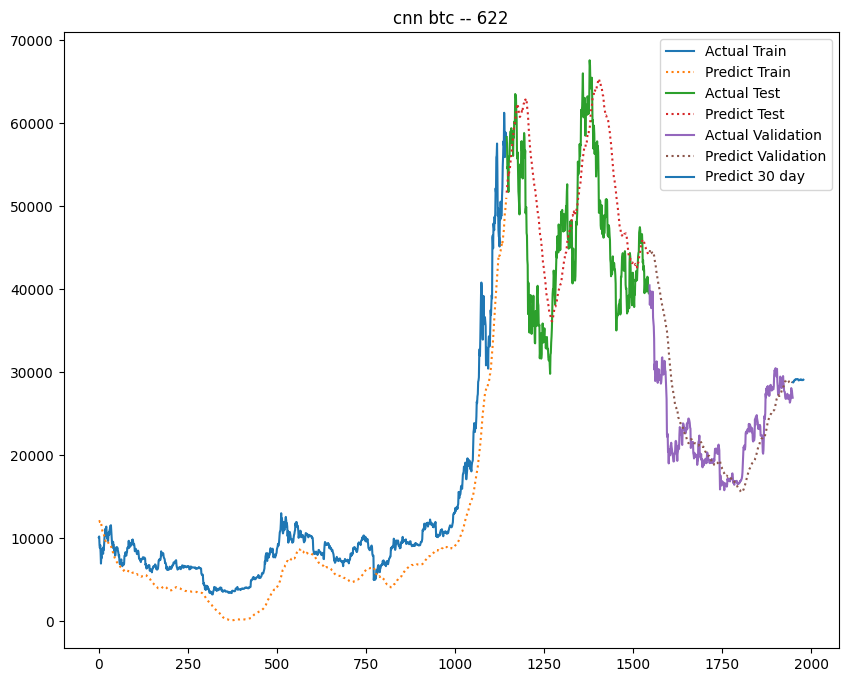

In [91]:

# Predict Next 30 days
npred = 30
i = 0
pred_list = []
input = Yval[-T:]

while i < npred:
  pred = model.predict(input.reshape(1, -1, 1))
  pred_list.append(pred)

  input = np.concatenate([input.squeeze(), pred.reshape(1, )])
  input = input[1:]
  i += 1

pred_list = np.array(pred_list)
pred_list = scaler.inverse_transform(pred_list.reshape(1, -1))

color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(10, 8))

# train
train_range = range(0, len(y_true_train.squeeze()))
plt.plot([*train_range], y_true_train.squeeze(), label="Actual Train", color = color_palette[0])
plt.plot([*train_range], pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_range = range(train_range[-1] + 1, train_range[-1] + 1 + len(y_true_test.squeeze()))
plt.plot([*test_range], y_true_test.squeeze(), label="Actual Test", color=color_palette[2])
plt.plot([*test_range], pred_test.squeeze(), label="Predict Test", linestyle="dotted", color=color_palette[3])

# val
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(y_true_val.squeeze()))
plt.plot([*val_range], y_true_val.squeeze(), label="Actual Validation", color=color_palette[4])
plt.plot([*val_range], pred_val.squeeze(), label="Predict Validation", linestyle="dotted",color=color_palette[5])

# 30 days
pred_range = range(val_range[-1] + 1, val_range[-1] + 1 + 30)
plt.plot([*pred_range], pred_list.squeeze(), label="Predict 30 day")

plt.legend()
plt.title(f"{model_name} {tokens[token_id]} -- {train_test_split[n_split]}")

save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_{train_test_split[n_split]}.png")
plt.show()